# Bibliotecas

In [1]:
import random
import re
import nltk
import unidecode
import math
import time
import string
import numpy as np
import pandas as pd
import seaborn as sns
import dataframe_image as dfi
import statsmodels.api as sm
from wordcloud import WordCloud
from numpy import mean
from nltk import tokenize
from string import punctuation
from string import ascii_letters
from nltk.stem import RSLPStemmer
from sklearn import metrics
from pandas_ods_reader import read_ods
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectPercentile
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
from matplotlib import pyplot as plt

# Funções

In [2]:
#Função para ler os dados e realizar algumas definições
#Entrada: Nenhuma
#Saída: Dataframe com os dados e os tipos atribuídos

def leitura_e_configuracao():
    df = read_csv("teste.csv")

    #Define os tipos de dados das colunas
    df['Palavras-chave'] = df['Palavras-chave'].astype(str)
    df['Título'] = df['Título'].astype(str)
    df['Resumo'] = df['Resumo'].astype(str)
    df['Categoria'] = df['Categoria'].astype(str)
    df['ID'] = df['ID'].astype(int)
    
    # atribuição dos ids a cada uma das categorias
    for abstract in df:
        df.loc[df['Categoria'] == 'Ciências Agrárias', 'ID_Categoria'] = 0
        df.loc[df['Categoria'] == 'Ciências Biológicas', 'ID_Categoria'] = 1
        df.loc[df['Categoria'] == 'Ciências Exatas e da Terra', 'ID_Categoria'] = 2
        df.loc[df['Categoria'] == 'Ciências Humanas', 'ID_Categoria'] = 3
        df.loc[df['Categoria'] == 'Ciências Sociais Aplicadas', 'ID_Categoria'] = 4
        df.loc[df['Categoria'] == 'Ciências da Saúde', 'ID_Categoria'] = 5
        df.loc[df['Categoria'] == 'Engenharias', 'ID_Categoria'] = 6
        df.loc[df['Categoria'] == 'Lingüística, Letras e Artes', 'ID_Categoria'] = 7
        df.loc[df['Categoria'] == 'Multidisciplinar', 'ID_Categoria'] = 8
        
        
    
    df['ID_Categoria'] = df['ID_Categoria'].astype(int) #tipo de dado da nova coluna criada
    df['Texto'] = df['Título'] + df['Resumo'] + df['Palavras-chave'] # Atributo texto é a união do título, resumo
                                                                     # e palavras-chave
    
    return df # retorna o dataframe

In [3]:
#Função para realizar o pré-processamento dos dados
#Entrada: Dataframe com os dados e o atributo a ser pré-processado
#Saída: Nenhuma

def pre_processamento(df, atributo):
    
    #letras minúsculas
    df[atributo] = [texto.lower() for texto in df[atributo]]

    #remoção de acentos
    df[atributo] = [unidecode.unidecode(texto) for texto in df[atributo]]

    #remoção de stop words
    stop_words = nltk.corpus.stopwords.words('portuguese')
    stop_words.extend(['artigo','sobre', 'resultado','objetivo','estudo','brasil', 'trabalho', 
                      'delineamento', 'experimental','analise'])
    lista_stopwords = []
    for abstract in df[atributo]:
        tokens = tokenize.WhitespaceTokenizer().tokenize(abstract)
        novo_texto = ' '.join([token for token in tokens if token not in stop_words])
        lista_stopwords.append(novo_texto)
    df[atributo] = lista_stopwords

    #remoção de pontuação
    pontuacoes = list(punctuation)
    pontuacao = []
    for texto in df[atributo]:
        tokens = tokenize.WhitespaceTokenizer().tokenize(texto)
        novo_texto = ' '.join([token for token in tokens if token not in pontuacoes])
        pontuacao.append(novo_texto)
    df[atributo] = pontuacao

    #Retira textos não desejados
    df[atributo] = df[atributo].apply(lambda x: re.sub(r'[0-9]','',x))
    df[atributo] = df[atributo].apply(lambda x: re.sub(r'[/(){}\[\]\#\|\%\@,;.:-]',' ',x))
    df[atributo] = df[atributo].apply(lambda x: re.sub(r'\d+', '', x))

    #obtenção da raíz das palavras
    stemmer = RSLPStemmer()
    raizes = []
    for texto in df[atributo]:
        tokens = tokenize.WhitespaceTokenizer().tokenize(texto)
        novo_texto = ' '.join([stemmer.stem(token) for token in tokens])
        raizes.append(novo_texto)
    df[atributo] = raizes

In [4]:
#Função para realizar a extração de características
#Entrada: Dataframe e o atributo correspondente
#Saída vetor de características e os rótulos das categorias

#teste

def extracao_caracteristicas(df, atributo):
    tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), max_df=7) # aplicação do TF-IDF para
                                                                                        # extração de características
    vetor_caracteristicas = tfidf.fit_transform(df[atributo]) # obtenção do vetor de características
    vetor_tfidf = vetor_caracteristicas.toarray()                  
    rotulos = df.ID_Categoria
    return vetor_caracteristicas, rotulos

In [5]:
#Função para realizar a seleção de características
#Entrada: vetor de características e os rótulos das categorias
#Saída: vetor de características atualizado

def selecao_caracteristicas(vetor_caracteristicas, rotulos):
    chi2_test = SelectPercentile(percentile=20) #Qui-Quadrado usando para
                                                                            #selecionar metade das amostras
    vetor_chi2 = chi2_test.fit_transform(vetor_caracteristicas,rotulos) # obtenção do vetor chi2
    vetor_caracteristicas = vetor_chi2 # obtenção do vetor de características
    return vetor_caracteristicas

In [6]:
#Função para realizar a validação do modelo usando 10-fold cross validation
#Entrada: Dataframe, classificador, vetor de características e os rótulos das categorias
#Saída: Dataframe com o resultado dos 10 folds

def validacao(df, modelo, vetor_caracteristicas, rotulos):
    
    vc_df = pd.DataFrame(index=range(10))
    entradas = []
    acuracias = cross_val_score(modelo, vetor_caracteristicas, rotulos, scoring='accuracy', cv=10)
    for num_fold, acuracia in enumerate(acuracias):
        entradas.append((num_fold, acuracia))
    vc_df = pd.DataFrame(entradas, columns=['num_fold', 'acuracia'])
    
    return vc_df

In [7]:
#Função para avaliar as dimensões de qualidade segundo os métodos de contaminação utilizando 10-fold cross validation
#e as condições experimentais de ruído
#Entrada: dimensão de qualidade a ser avaliada, atributo alvo, algoritmo de classificação selecionado
#Saída: lista contendo uma lista de 10 folds para cada condição experimental avaliada

def avaliacao_DQ(dimensao, atributo, classificador):
    ruidos = [0, 10, 20, 30, 40] # Grupo Controle, Grupo I, Grupo II, Grupo III, Grupo IV
    folds = []
    for ruido in ruidos:
        df = leitura_e_configuracao() # leitura/configuração do dataframe
        #contaminação
        if(dimensao == 'Acurácia-add'):
            contamina_acuracia(df, atributo, 'adicao', ruido)
        elif(dimensao == 'Acurácia-rm'):
            contamina_acuracia(df, atributo, 'remocao', ruido)
        elif(dimensao == 'Acurácia-subs'):
            contamina_acuracia(df, atributo, 'substituicao', ruido)
        elif(dimensao == 'Completude'):
            contamina_completude(df, atributo, ruido)
        elif(dimensao == 'Consistência'):
            contamina_consistencia(df, atributo, ruido)
        pre_processamento(df, atributo) # pré-processamento após a contaminação
        vetor_caracteristicas, rotulos = extracao_caracteristicas(df, atributo) #extração de características
        vetor_caracteristicas = selecao_caracteristicas(vetor_caracteristicas, rotulos)#seleção de características
        vc_df = validacao(df, classificador, vetor_caracteristicas, rotulos)#validação do modelo
        folds.append(vc_df.acuracia.values) # adiciona os 10 folds do grupo ruído à lista de folds
        
    return folds

In [8]:
#Função para realizar a contaminação da dimensão de qualidade Acurácia
#Entrada: dataframe, atributo escolhido, método(adição,remoção,substituição), porcentagem de ruído
#Saída: dataframe modificado

def contamina_acuracia(df, escolha_atributo, metodo, porc_ruido):
    lista_artigos = []
    
    if (porc_ruido == 0): # retorna caso não haja contaminação
        return
    
    qtd_artigos = int(df.shape[0] * (porc_ruido/100)) # quantidade de artigos que serão contaminados
    atributo_contaminado = escolha_atributo 
    i = 0
    
    while i < qtd_artigos: # laço para contaminar os artigos
        
        lista_caracteres = []
        lista_final = []
        indice = random.choice(df.index) # artigo é selecionado de maneira aleatória
        
        if indice in lista_artigos: # verifica se o artigo já foi contaminado previamente
            while indice in lista_artigos:
                indice = random.choice(df.index)
        
        lista_caracteres = [carac for carac in df.loc[indice, atributo_contaminado]]
        
        for carac in lista_caracteres: # percorre os caracteres
            
            if (random.random() <= 0.1): # se o caracter for contaminado
                
                caracter = random.choice(ascii_letters) # obtém um caracter aleatório
                
                if(not caracter.isalpha()): # gera novo caracter enquanto este não for alfabético
                    while(not caracter.isalpha()):
                        caracter = random.choice(ascii_letters)
                                
                if(metodo == 'substituicao'): # método de substituição de caracteres
                    lista_final.append(caracter) # adiciona o caracter aleatório no lugar do antigo na nova lista
                elif(metodo == 'adicao'): # método de adição de caracteres
                    lista_final.extend([carac, caracter]) # adiciona o caracter antigo junto com o aleatório
                                                               # à nova lista
                elif(metodo == 'remocao'): # remoção de caracteres
                    pass # caso o caracter seja contaminado, ele não é adicionado à lista de caracteres
            
            else: # caracter não será contaminado
                lista_final.append(carac)
                
        df.loc[indice, atributo_contaminado] = ''.join([carac for carac in lista_final]) # substitui o artigo pela
                                                                                         # lista resultante
        lista_artigos.append(indice) # adiciona o índice do artigo à lista de artigos contaminados
        i+=1

In [9]:
#Função para realizar a contaminação da dimensão de qualidade Completude
#Entrada: dataframe, atributo escolhido, porcentagem de ruído
#Saída: dataframe modificado        

def contamina_completude(df, escolha_atributo, porc_ruido):
    lista_artigos = []
    #lista_atributos = ['Título', 'Resumo', 'Palavras-chave']
    if(porc_ruido == 0):
        return
    qtd_artigos = int(df.shape[0] * (porc_ruido/100))
    i = 0
    atributo_contaminado = escolha_atributo
    while i < qtd_artigos:
        indice = random.choice(df.index) # sorteia um artigo aleatório
        if indice in lista_artigos: # se o artigo já foi contaminado
            while indice in lista_artigos: # procura por um novo artigo enquanto estiver na lista dos que já foram contaminados
                indice = random.choice(df.index)
        df[atributo_contaminado] = df[atributo_contaminado].replace([df[atributo_contaminado][indice]], '') # apaga o atributo
        lista_artigos.append(indice) # adiciona o artigo contaminado à lista de artigos que já foram contaminados
        i += 1

In [10]:
#Função para realizar a contaminação da dimensão de qualidade Consistência
#Entrada: dataframe, atributo escolhido, porcentagem de ruído
#Saída: dataframe modificado         
        
def contamina_consistencia(df, escolha_atributo1, porc_ruido):
    lista_artigos = []
    lista_atributos = ['Título', 'Resumo', 'Palavras-chave']
    if(porc_ruido == 0):
        return
    porc_ruido /= 2
    qtd_artigos = int(df.shape[0] * (porc_ruido/100)) # número de artigos a serem contaminados
    i = 0
    atributo_contaminado1 = escolha_atributo1
    atributo_contaminado2 = random.choice(lista_atributos)
    while i < qtd_artigos:
        indice1 = random.choice(df.index)
        indice2 = random.choice(df.index)
        if(df['ID_Categoria'][indice1] == df['ID_Categoria'][indice2]):
                while(df['ID_Categoria'][indice1] == df['ID_Categoria'][indice2]):
                        indice1 = random.choice(df.index)
        
        else:
            temp = df[atributo_contaminado1][indice1]
            if(atributo_contaminado2 == atributo_contaminado1):
                while(atributo_contaminado2 == atributo_contaminado1):
                    atributo_contaminado2 = random.choice(lista_atributos)
            df[atributo_contaminado1] = df[atributo_contaminado1].replace([df[atributo_contaminado1][indice1]], [df[atributo_contaminado2][indice2]])
            df[atributo_contaminado2] = df[atributo_contaminado2].replace([df[atributo_contaminado2][indice2]], temp)
            i+=1

In [11]:
#Função para obter a melhor divisão do conjunto de treinamento/teste e exibir graficamente
#Entrada: classificador
#Saída: indicação gráfica da melhor porcentagem de amostras usadas para o treinamento do modelo de classificação
            
def melhor_divisao(modelo):
    lista_acuracias = []
    lista_porc = []
    i = 0.01 # Começa em 1%
    while i < 1: # Enquanto não chegar a 100%
        X_train, X_test, y_train, y_test = train_test_split(vetor_caracteristicas, rotulos, train_size=i, stratify=rotulos, random_state=0)
        modelo.fit(X_train, y_train) # faz o treinamento usando a porcentagem i como conjunto de treino
        y_pred = modelo.predict(X_test)
        lista_acuracias.append(accuracy_score(y_test, y_pred)*100)
        lista_porc.append(i*100)
        i += 0.01
    
    #configuração do gráfico a ser exibido
    fig, ax = plt.subplots()
    ax.plot(lista_porc, lista_acuracias, 'black')
    plt.xlabel('Conjunto de Treino (%)')
    plt.ylabel('Acurácia (%)')
    indice = lista_acuracias.index(max(lista_acuracias))
    plt.scatter(lista_porc[indice], max(lista_acuracias), c='red', linewidths=2)
    plt.axhline(y=max(lista_acuracias), xmax=lista_porc[indice]/105, linestyle='--', color="red")
    plt.axvline(x=lista_porc[indice], ymax=max(lista_acuracias)/(max(lista_acuracias)+5), linestyle='--', color="red")
    plt.text(lista_porc[indice]+2, max(lista_acuracias)+0.5, '({:.1f}, {:.1f})'.format(lista_porc[indice], max(lista_acuracias)))
    plt.margins(0.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(25,100)
    plt.show()

In [12]:
#Função para gerar as curvas ROC e disponibilizá-las em formato gráfico
#Entrada: classificador e melhor divisão do conjunto de treino
#Saída: representação gráfica das curvas ROC para o modelo escolhido
    
def gera_curvas_roc(modelo, cjto_treino):

    #treinamento do modelo utilizando o melhor split possível
    X_train, X_test, y_train, y_test = train_test_split(vetor_caracteristicas, rotulos, train_size=(cjto_treino/100), stratify=rotulos, random_state=0)
    modelo = OneVsRestClassifier(modelo)
    try:
        pred_prob = modelo.fit(X_train, y_train).decision_function(X_test)   
    except AttributeError:
        pred_prob = modelo.predict_proba(X_test)
        
    y_pred = modelo.predict(X_test)
    #pred_prob =  #obtenção das probabilidades que serão utilizadas para construir as
                                             #curvas ROC
    
    FPR = {} #dicionário contendo os pares chave-valor dos falsos positivos (1-Especificidade)
    TPR = {} #dicionárito contendo os pares chave-valor dos verdadeiros positivos (Sensibilidade)
    limite = {}
    AUC = {}

    num_classes = 9
    
    
    for i in range(num_classes):
        FPR[i], TPR[i], limite[i] = roc_curve(y_test, pred_prob[:, i], pos_label=i) #obtenção das curvas ROC
                                                                                    #para as nove classes
            
        
        AUC[i] = auc(FPR[i], TPR[i])
            
    
    # plotando a área sob a curva e configurando exbição do gráfico
    fig, ax = plt.subplots()
    plt.plot(FPR[0], TPR[0], color='#e41a1c', linestyle='-', label='CA vs Outras', linewidth=5)
    plt.plot(FPR[1], TPR[1], color='#377eb8', linestyle='-', label='CB vs Outras',linewidth=5)
    plt.plot(FPR[2], TPR[2], color='#4daf4a', linestyle='-', label='CET vs Outras', linewidth=5)
    plt.plot(FPR[3], TPR[3], color='#984ea3', linestyle='-', label='CH vs Outras', linewidth=5)
    plt.plot(FPR[4], TPR[4], color='#ff7f00', linestyle='-', label='CSA vs Outras', linewidth=5)
    plt.plot(FPR[5], TPR[5], color='#ffff33', linestyle='-', label='CS vs Outras', linewidth=5)
    plt.plot(FPR[6], TPR[6], color='#a65628', linestyle='-', label='E vs Outras', linewidth=5)
    plt.plot(FPR[7], TPR[7], color='#f781bf', linestyle='-', label='LLA vs Outras', linewidth=5)
    plt.plot(FPR[8], TPR[8], color='#999999', linestyle='-', label='M vs Outras', linewidth=5)
    plt.xlabel('1 - Especificidade', weight='book')
    plt.ylabel('Sensibilidade', weight='book')
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    leg = plt.legend(bbox_to_anchor=(1, 0.1), loc='lower right', borderaxespad=0., fontsize=34, shadow=False,
                     fancybox=False, ncol=2)
    leg.get_frame().set_linewidth(3)
    for i in range(num_classes):
        leg.get_lines()[i].set_linewidth(5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), linewidth=2)
    fig.set_size_inches(20, 10)
    
    
    plt.show()
    
    return AUC

In [13]:
#Função para criar o box-plot contendo os dados dos 10 folds obtidos por meio do 10-fold cross validation para cada
#um dos algoritmos
#Entrada: valores do eixo x, valores do eixo y e fonte dos dados
#Saída: Representação gráfica do box-plot
    
def cria_box_plot(eixo_x, eixo_y):

    #configuração do gráfico
    fig, ax = plt.subplots()
    flierprops = dict(marker='*', markerfacecolor='black', markersize=8,
                  markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1)
    boxprops = dict(linestyle='-', linewidth=1)
    whiskerprops = dict(linewidth=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.set_ylim(25,75)
    #cores = {
    #    'SVM':'blue',
    #    'NB':'orange',
    #    'LR': 'green'}
    
    #modelos a serem validados
    modelos = [
    LinearSVC(random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='liblinear')
]
    
    vc_df = pd.DataFrame(index=range(10 * len(modelos))) #dataframe para os folds da validação cruzada

    entradas = []
    
    #10-fold cross validation
    for modelo in modelos:
        nome_modelo = modelo.__class__.__name__
        if(nome_modelo == "LinearSVC"):
            nome_modelo = "SVM"
        elif(nome_modelo == "MultinomialNB"):
            nome_modelo = "NB"
        elif(nome_modelo == "LogisticRegression"):
            nome_modelo = "LR"
        acuracias = cross_val_score(modelo, vetor_caracteristicas, rotulos, scoring='accuracy', cv=10)
        for num_fold, acuracia in enumerate(acuracias):
            entradas.append((nome_modelo, num_fold, acuracia))
    
    #Adequação do dataframe
    vc_df = pd.DataFrame(entradas, columns=['Classificador', 'Num_Fold', 'Acurácia (%)'])
    vc_df['Acurácia (%)'] = [acuracia * 100 for acuracia in vc_df['Acurácia (%)']]

    #Construção do boxplot
    ax = sns.boxplot(x=eixo_x, y=eixo_y, palette=None, data=vc_df, orient='v', width=0.3,
           saturation=1, linewidth=1, showcaps=False, flierprops=flierprops, medianprops=medianprops,
               boxprops=boxprops, whiskerprops=whiskerprops, color=None)
    
    # caixas preto e branco
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
    
    plt.show()
    
    return vc_df

In [14]:
#Função para realizar a leitura e configuração dos resultados dos folds
    
def leitura_e_configuracao_resultados():

    df_resultados = read_ods("resultadosFolds.ods",1)

    #Define os tipos de dados das colunas
    df_resultados['Classificador'] = df_resultados['Classificador'].astype(str)
    df_resultados['Método'] = df_resultados['Método'].astype(str)
    df_resultados['Atributo'] = df_resultados['Atributo'].astype(str)
    df_resultados['Fold'] = df_resultados['Fold'].astype(int)
    df_resultados['Grupo'] = df_resultados['Grupo'].astype(str)
    df_resultados['Acurácia'] = df_resultados['Acurácia'].astype(float)
    
    return df_resultados

In [15]:
#Função para definir cores do Box-plot    

def setCorBoxPlot(bp, cor):
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='black')
    plt.setp(bp["boxes"], facecolor=cor)

In [16]:
#Função para criar os box-plots para os algoritmos sob as condições experimentais de ruído e um método de contaminação
#Entrada: dataframe, atributo contaminado, método de contaminação, eixo do gráfico construído
#Saída: gráfico com quatro quadrantes, onde cada um contém os box-plots dos classificadores
#e representam o atributo contaminado segundo as condições experimentais de ruído

def cria_box_plots(df, atributo, metodo, ax):
    
    #configurações do box-plot
    flierprops = dict(marker='*', markerfacecolor='black', markersize=8,
                  markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1)
    boxprops = dict(linestyle='-', linewidth=1)
    whiskerprops = dict(linewidth=1)
    
    classificadores = ['MVS','NBM','RL'] #classificadores
    posicoes = [[1,2,3,4,5],[8,9,10,11,12],[15,16,17,18,19]] #posições dos box-plots
    grupos_ruido = ['C','I','II','III','IV'] #condições experimentais
    
    for i in range(len(classificadores)): # para cada classificador
        
        lista_ruidos = []
        for j in range(len(grupos_ruido)):
            #filtra o dataframe com as colunas desejadas
            df_ruido = pd.DataFrame(df[(df['Grupo'] == grupos_ruido[j]) 
                                                          & (df['Classificador'] == classificadores[i])
                                                          & (df['Atributo'] == atributo) 
                                                          & (df['Método'] == metodo)])
            lista_ruidos.append(df_ruido['Acurácia']) #inclui apenas os valores de acurácia na lista
        
        bp = ax.boxplot(lista_ruidos, positions=posicoes[i], patch_artist=True, flierprops=flierprops,
                    medianprops=medianprops, boxprops=boxprops, showcaps=False, labels=grupos_ruido, widths=0.55,
                       whiskerprops=whiskerprops) #constroi o box-plot do classificador
        #define as cores
        if i == 0:
            setCorBoxPlot(bp,'blue')
        elif i == 1:
            setCorBoxPlot(bp,'orange')
        elif i == 2:
            setCorBoxPlot(bp,'green')

    #configurações dos eixos
    ax.set_yticks([30,40,50,60,70])
    ax.set_xlim(0,20)
    ax.set_ylim(25,75)
    ax.set_ylabel('Acurácia (%)', labelpad=20, fontdict=dict({'weight':'book'}))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    #adição do rótulo correspondente ao classificador utilizado no eixo x
    secax = ax.secondary_xaxis(-0.1)
    secax.xlim = (0,20)
    secax.spines['bottom'].set_visible(False)
    secax.set_xticks([3,10,17])
    secax.set_xticklabels(classificadores)
    secax.tick_params(axis='x', length=0)
    
    #adição do titulo ao subplot indicando o atributo correspondente
    #ax.set_title('{}'.format(atributo), y=1.1, pad=-10, loc='center', position=(0.5, 0.5))


In [17]:
#Função para criar o grid e os 4 quadrantes onde serão colocados os box-plots
#Saída: os axis representando cada um dos quadrantes

def set_grid(metodo):
    fig = plt.figure(figsize=(20,10)) #criação da figura
    plt.ylabel("Acurácia (%)", labelpad=80) #título eixo y
    #omissão dos ticks dos eixos para não sobressair
    plt.yticks([])
    plt.xticks([])
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0) #especificações do grid
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row') #compartilhamento das linhas e colunas
    
    return ax1,ax2,ax3,ax4


In [18]:
def similaridade_cossenos(vet):
    return vet.dot(vet.T)
    
    

# Pré-processamento/Extração/Seleção

In [19]:
#teste
df = leitura_e_configuracao()

In [20]:
df = df.drop_duplicates(subset=['Título'])
df = df.drop_duplicates(subset=['Resumo'])
df = df.drop_duplicates(subset=['Palavras-chave'])

In [21]:
pre_processamento(df, 'Texto')

In [22]:
vetor_caracteristicas, rotulos = extracao_caracteristicas(df, 'Texto')

In [23]:
vetor_caracteristicas = selecao_caracteristicas(vetor_caracteristicas, rotulos)

In [ ]:
df = df.drop(columns=['ID_Categoria', 'Texto'])

In [ ]:
df.to_csv('teste.csv', index=False)

In [ ]:
vetor_caracteristicas.shape

# Testes

## Testes-Contaminação

In [ ]:
%%time
atributo = 'Texto'
metodo = 'Acurácia-add'
modelo = modelo = LogisticRegression(random_state=0, solver='liblinear')

lista_folds = []
i=0
arquivo = open("resultados/rl/acc/{}-{}-ACC.txt".format(atributo, metodo),"w")
arquivo_folds = open("resultados/rl/folds/{}-{}-FOLDS.txt".format(atributo, metodo),"w")
for i in range(10):
    folds = avaliacao_DQ(metodo, atributo, modelo)
    lista_folds.append(folds)
lista_media_folds = [sum(val)/10 for val in zip(*lista_folds)]
for media_fold in lista_media_folds:
    arquivo.write("{}\n".format((sum(media_fold)/len(media_fold))*100))
    for fold in media_fold:
        arquivo_folds.write("{}\n".format(fold*100))
print("{}: {} ✔\n".format(atributo, metodo))
arquivo.close()
arquivo_folds.close()

## Outros Testes

In [ ]:
df_teste = leitura_e_configuracao()

In [ ]:
artigo = df_teste.sample(n=1)

In [ ]:
artigo['Palavras-chave'].values

In [ ]:
contamina_acuracia(artigo, 'Palavras-chave', 'remocao', 100)

In [ ]:
artigo['Palavras-chave'].values

In [ ]:

wordcloud = WordCloud(collocations = False, background_color = 'white').generate(''.join(df['Texto']))

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
fd = nltk.FreqDist(df['TextoTokenizado'][1])

for palavra in list(fd.keys())[:10]:
    print(palavra, fd[palavra])

In [ ]:
string = ' '.join(df['Texto'])

tokens = tokenize.WhitespaceTokenizer().tokenize(string)

In [ ]:
fd = nltk.FreqDist(tokens)

df_view = sorted(((v,k) for k,v in fd.items()), reverse=True)

for v,k in df_view:
    print (v, k)

#for palavra in list(fd.keys())[:10]:
#    print(palavra, fd[palavra])

In [ ]:
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(string)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Análise dos dados

In [ ]:
freq = df['Categoria'].value_counts()
freq

In [ ]:
texto = df['Texto'][0]
texto

In [ ]:
areas = ['Ciências Agrárias', 'Ciências Biológicas', 'Ciências Exatas e da Terra', 'Ciências Humanas',
        'Ciências Sociais Aplicadas', 'Ciências da Saúde', 'Engenharias', 'Lingüística, Letras e Artes', 
         'Multidisciplinar']

media_palavras_por_area = []
media_caracteres_por_area = []

for area in areas:
    
    n_palavras = []
    n_caracteres = []
    df_area = pd.DataFrame(data = df.loc[df['Categoria'] == area])
    for texto in df_area['Texto']:   
        n_palavras.append(len(texto.split()))
        n_caracteres = len(''.join(texto.split()))
    
    media_caracteres_por_area.append(mean(n_caracteres))
    media_palavras_por_area.append(mean(n_palavras))
    
media_palavras_por_area = [round(area,0) for area in media_palavras_por_area]

print("Média de palavras por área do conhecimento:\n")
for i in range(len(areas)):
    print(f"{areas[i]}: {media_palavras_por_area[i]}")
    
print(f"\nMédia de caracteres por área do conhecimento:\n")
for i in range(len(areas)):
    print(f"{areas[i]}: {media_caracteres_por_area[i]}")

In [ ]:
print(mean(media_palavras_por_area))
print(mean(media_caracteres_por_area))

In [ ]:
from pandas import option_context

with option_context('display.max_colwidth', 20):
    display(df.sample(3))

In [ ]:
dfi.export(df.sample(5),'imagem_bdc')

## Visualização das classes

In [ ]:
df['Categoria'].value_counts()
    

In [ ]:



cores = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']

fig, ax = plt.subplots(figsize=(10,10))

ax.pie(tamanhos, labels=df['Categoria'].unique(), shadow=True, colors=cores, startangle=90, autopct='%1.2f%%')
ax.axis('equal')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 32
plt.show()

# Validação

## Validação cruzada

In [ ]:
vc_df = cria_box_plot('Classificador', 'Acurácia (%)')

In [ ]:
vc_df

In [ ]:
vc_df['Acurácia'] = vc_df['Acurácia (%)']
acuracias = vc_df.groupby('Classificador').Acurácia.mean()
acuracias.sort_values(ascending=False)

In [ ]:
acuracias_desvios = vc_df.groupby('Classificador').Acurácia.std()
acuracias_desvios.sort_values(ascending=False)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
cv2 = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)
cv3 = RepeatedStratifiedKFold(n_splits=10, random_state=0)

In [ ]:
%%time
modelo = MultinomialNB()
acuracias = cross_val_score(modelo, vetor_caracteristicas, rotulos, scoring='accuracy', cv=cv)
print(mean(acuracias)*100)

In [ ]:
print(acuracias*100)

In [ ]:
acuracias.std()

## Leave-one-out

In [ ]:
%%time
loo = LeaveOneOut()
LinearSVC(random_state=0, multi_class='ovr')
acuracia = cross_val_score(modelo, vetor_caracteristicas, rotulos, scoring='accuracy', cv=loo)
print(mean(acuracia)*100)

## Divisão treino/teste

In [ ]:
melhor_divisao(LinearSVC(random_state=0))

In [ ]:
melhor_divisao(MultinomialNB())

In [ ]:
melhor_divisao(LogisticRegression(random_state=0, solver='liblinear'))

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(vetor_caracteristicas, rotulos, train_size=0.90, random_state=0, stratify=rotulos)
modelo = LinearSVC(random_state=0, multi_class='ovr')
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)

## Matriz de confusão

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

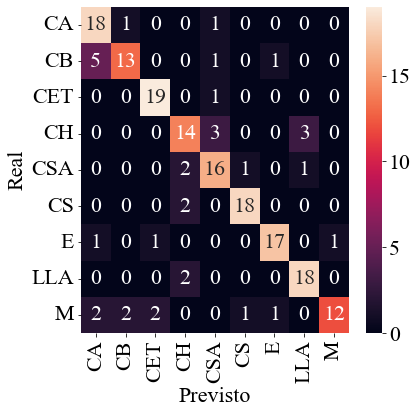

              precision    recall  f1-score   support

          CS       0.69      0.90      0.78        20
          CH       0.81      0.65      0.72        20
          CA       0.86      0.95      0.90        20
         CSA       0.70      0.70      0.70        20
           E       0.73      0.80      0.76        20
         LLA       0.90      0.90      0.90        20
          CB       0.89      0.85      0.87        20
         CET       0.82      0.90      0.86        20
           M       0.92      0.60      0.73        20

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.80       180
weighted avg       0.81      0.81      0.80       180



In [32]:
#teste
#modelo = LinearSVC(random_state=0)
modelo = MultinomialNB()
#modelo = LogisticRegression(random_state=0, solver='liblinear')

X_train, X_test, y_train, y_test = train_test_split(vetor_caracteristicas, rotulos, train_size=0.90, stratify=rotulos, random_state=0)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

#criação de dicionário (categoria,id)
category_id_df = df[['Categoria', 'ID_Categoria']].drop_duplicates().sort_values('ID_Categoria')
#criação de dicionário (id, categoria)
id_to_category = dict(category_id_df[['ID_Categoria', 'Categoria']].values)

#criação das siglas
category_id_df.loc[category_id_df['Categoria'] == 'Ciências Agrárias', 'Categoria'] = 'CA'
category_id_df.loc[category_id_df['Categoria'] == 'Ciências Biológicas', 'Categoria'] = 'CB'
category_id_df.loc[category_id_df['Categoria'] == 'Ciências Exatas e da Terra', 'Categoria'] = 'CET'
category_id_df.loc[category_id_df['Categoria'] == 'Ciências Humanas', 'Categoria'] = 'CH'
category_id_df.loc[category_id_df['Categoria'] == 'Ciências Sociais Aplicadas', 'Categoria'] = 'CSA'
category_id_df.loc[category_id_df['Categoria'] == 'Ciências da Saúde', 'Categoria'] = 'CS'
category_id_df.loc[category_id_df['Categoria'] == 'Engenharias', 'Categoria'] = 'E'
category_id_df.loc[category_id_df['Categoria'] == 'Lingüística, Letras e Artes', 'Categoria'] = 'LLA'
category_id_df.loc[category_id_df['Categoria'] == 'Multidisciplinar', 'Categoria'] = 'M'

#matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat.diagonal()/conf_mat.sum(axis=0)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
xticklabels=category_id_df.Categoria.values, yticklabels=category_id_df.Categoria.values)
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

#imprime as métricas
print(metrics.classification_report(y_test, y_pred, target_names=df['Categoria'].unique(), digits=2))

## Curvas-ROC

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 40

In [ ]:
from sklearn.svm import SVC

#AUC_SVM = gera_curvas_roc(LinearSVC(random_state=0, multi_class='ovr'), 90)
#AUC_NB = gera_curvas_roc(MultinomialNB(), 90)
AUC_LR = gera_curvas_roc(LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr'), 90)

In [ ]:
#print({k: v for k, v in sorted(AUC_SVM.items(), key = lambda item: item[1], reverse=True)})
#print({k: v for k, v in sorted(AUC_NB.items(), key = lambda item: item[1], reverse=True)})
print({k: v for k, v in sorted(AUC_LR.items(), key = lambda item: item[1], reverse=True)})

In [ ]:
format(0.9556250000000001)

## Box-Plots

In [ ]:
df_resultados = leitura_e_configuracao_resultados()
atributos = ('Título','Resumo','Palavras-chave','Texto')

In [ ]:
#ax1,ax2,ax3,ax4 = set_grid('Acurácia')

#fig, axs = plt.subplots(2,2, figsize=(25,15))

for att in atributos:
    fig, ax = plt.subplots(figsize=(6,4))
    cria_box_plots(df_resultados, att, 'ACC', ax)

#plt.subplot(2,2,1)
#cria_box_plots(df_resultados, 'Título', 'ACC', axs[0,0])
#plt.subplot(2,2,2)
#cria_box_plots(df_resultados, 'Resumo', 'ACC', axs[0,1])
#fig.tight_layout(pad=3.0)
#plt.subplot(2,2,3)
#cria_box_plots(df_resultados, 'Palavras-chave', 'ACC', axs[1,0])
#plt.subplot(2,2,4)
#cria_box_plots(df_resultados, 'Texto', 'ACC', axs[1,1])

In [ ]:
for att in atributos:
    fig, ax = plt.subplots(figsize=(6,4), linewidth=20)
    cria_box_plots(df_resultados, att, 'COMP', ax)

In [ ]:
for att in atributos:
    fig, ax = plt.subplots(figsize=(6,4), linewidth=20)
    cria_box_plots(df_resultados, att, 'CONS', ax)

## Gráfico de Linha

In [ ]:
def getAcuracia(df, grupo, classificador, atributo, dimensao):

    df_ruido = pd.DataFrame(df[(df['Grupo'] == grupo) 
                                                        & (df['Classificador'] == classificador)
                                                        & (df['Atributo'] == atributo) 
                                                        & (df['Método'] == dimensao)])
    return mean(df_ruido['Acurácia'])

In [ ]:
def grafico_linha(df, atributo, dimensao, ax):

    grupos = ('C','I','II','III','IV')
    classificadores = ('MVS','NBM','RL')
    atributos = ('Título','Resumo','Palavras-chave','Texto')
    dimensoes = ('ACC','COMP','CONS')
    
    cores = ('red','green','blue')

    i=0
    for classificador in classificadores:
        acuracias = []
        for g in grupos:
            acuracias.append(getAcuracia(df, g, classificador, atributo, dimensao))
        ax.plot(grupos,acuracias, label=classificador, marker='o', color=cores[i])
        ax.legend(fontsize='small', loc='lower right', fancybox=True, shadow=True)
        i+=1
            
    #configurações dos eixos
    ax.set_yticks([15,30,45,60])
    ax.set_xlim(-1,5)
    ax.set_ylim(14,66)
    
    #adição do titulo ao subplot indicando o atributo correspondente
    ax.set_title('{}'.format(atributo), y=1.1, pad=-10, loc='center', position=(0.5, 0.5))



In [ ]:
ax1,ax2,ax3,ax4 = set_grid('Acurácia')

grafico_linha(df_resultados, 'Título','ACC', ax1)
grafico_linha(df_resultados, 'Resumo','ACC', ax2)
grafico_linha(df_resultados, 'Palavras-chave','ACC', ax3)
grafico_linha(df_resultados, 'Texto','ACC', ax4)

In [ ]:
ax1,ax2,ax3,ax4 = set_grid('Completude')

grafico_linha(df_resultados, 'Título','COMP', ax1)
grafico_linha(df_resultados, 'Resumo','COMP', ax2)
grafico_linha(df_resultados, 'Palavras-chave','COMP', ax3)
grafico_linha(df_resultados, 'Texto','COMP', ax4)

## Two-Way ANOVA

In [ ]:
import pingouin as pg

In [ ]:
df_resultados = leitura_e_configuracao_resultados()

In [ ]:
def two_way_anova(df, metodo, atributo):
    
    df_anova = pd.DataFrame(df[(df['Atributo'] == atributo) & (df['Método'] == metodo)])
    
    aov = pg.anova(dv='Acurácia', between=['Classificador', 'Grupo'], data=df_anova,
             detailed=True)
    
    return df_anova, aov

In [ ]:
def media_anova(df):
    
    grupos = ['C','I','II','III','IV']
    lista_media_grupos = []
    
    for grupo in grupos:
        df_grupo = pd.DataFrame(df[(df['Grupo'] == grupo)])
        lista_media_grupos.append(df_grupo['Acurácia'].mean())
    
    return lista_media_grupos

In [ ]:
atributos = ['Título', 'Resumo','Palavras-chave','Texto']
metodos = ['ACC', 'COMP', 'CONS']

for metodo in metodos:
    print('\n{}\n'.format(metodo))
    for atributo in atributos:
        
        df_anova, anova = two_way_anova(df_resultados,metodo,atributo)
        lista_medias = media_anova(df_anova)
        
        total = np.array([['Total',sum(anova['SS'].values), sum(anova['DF'].values)]])
        total_anova = pd.DataFrame(data=total, columns=['Source','SS', 'DF'])
        anova = anova.append(total_anova)
        
        display('{}'.format(atributo), anova)
        print("Médias: {}".format(lista_medias))
        


# Similaridade entre as áreas do conhecimento

In [25]:
df.loc[df['Categoria'] == 'Ciências Agrárias', 'Categoria'] = 'CA'
df.loc[df['Categoria'] == 'Ciências Biológicas', 'Categoria'] = 'CB'
df.loc[df['Categoria'] == 'Ciências Exatas e da Terra', 'Categoria'] = 'CET'
df.loc[df['Categoria'] == 'Ciências Humanas', 'Categoria'] = 'CH'
df.loc[df['Categoria'] == 'Ciências Sociais Aplicadas', 'Categoria'] = 'CSA'
df.loc[df['Categoria'] == 'Ciências da Saúde', 'Categoria'] = 'CS'
df.loc[df['Categoria'] == 'Engenharias', 'Categoria'] = 'E'
df.loc[df['Categoria'] == 'Lingüística, Letras e Artes', 'Categoria'] = 'LLA'
df.loc[df['Categoria'] == 'Multidisciplinar', 'Categoria'] = 'M'

## PCA

In [39]:
pca = PCA(n_components=2, random_state=0)

In [34]:
#pcaCalc = pca.fit_transform(X_test.toarray())
pcaCalc = pca.fit_transform(vetor_caracteristicas.toarray())

In [35]:
dfPrincipal = pd.DataFrame(data=pcaCalc, columns=['PCA1','PCA2'])

In [36]:
#dfFinal = pd.concat((dfPrincipal, test_df['Categoria']), axis=1)
dfFinal = pd.concat((dfPrincipal, df['Categoria']), axis=1)

In [37]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 22

In [ ]:
dfFinal.loc[dfFinal['PCA1'] < 0.1]

In [ ]:
dfFinal.loc[dfFinal['PCA2'] < 0.1]

In [ ]:
dfFinal.loc[dfFinal['PCA1'] > 0.7]

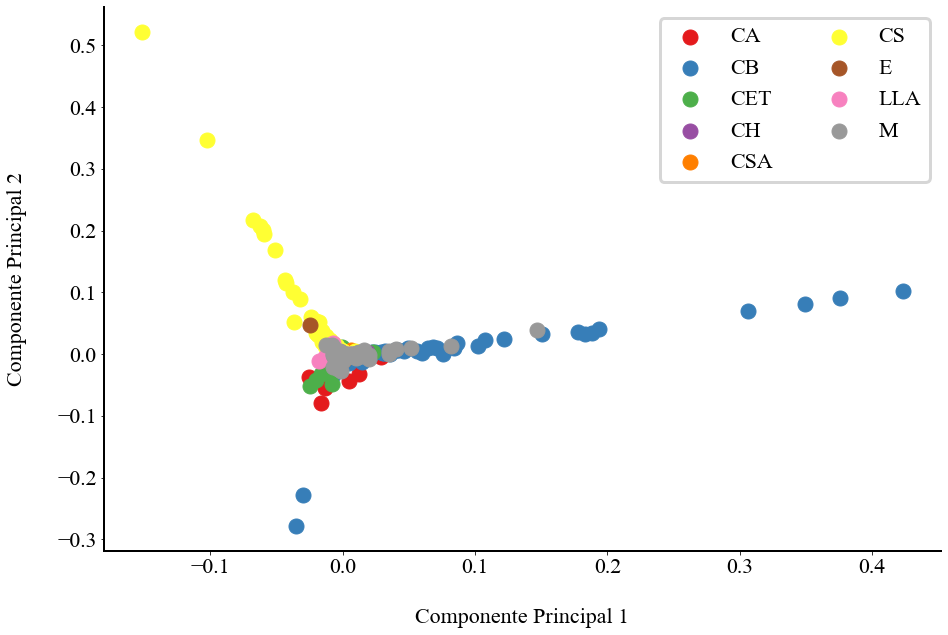

In [38]:
areas = ['CA', 'CB', 'CET', 'CH', 'CSA', 'CS', 'E', 'LLA', 'M']
cores_areas = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
#cores_areas = ['#e41a1c', '#377eb8', '#999999', '#984ea3', '#ff7f00', '#999999', '#999999', '#999999', '#999999']

fig, ax = plt.subplots(1,1,figsize=(15,10))

for alvo, cor in zip(areas, cores_areas):
    indices = dfFinal['Categoria'] == alvo
    ax.scatter(dfFinal.loc[indices, 'PCA1'],
                 dfFinal.loc[indices, 'PCA2'],
                  c=cor,
                  s=900,
                  marker='.')
        

ax.set_xlabel('Componente Principal 1', labelpad=30)
ax.set_ylabel('Componente Principal 2', labelpad=30)
#ax.set_xlim(-0.1,0.1)
#ax.set_ylim(-0.2,0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)


#ax.set_xlim(-0.01,0.01)
#ax.set_ylim(-0.01,0.01)

leg = ax.legend(areas, loc='best', ncol=2)
leg.get_frame().set_linewidth(3)

#plt.axvline(x=0, ymin=0, linewidth=2, color='k')
#plt.axhline(y=0, xmin=0, linewidth=2, color='k')

In [ ]:
df.loc[df['ID'] == 20]

In [ ]:
areas_similares = ['CA', 'CB','CH', 'CSA']
areas_similares_ca_cb = ['CA', 'CB']
areas_similares_ch_csa = ['CH','CSA']
areas_nao_similares = ['CET', 'CS', 'E', 'LLA', 'M']
areas = ['CA', 'CB', 'CET', 'CH', 'CSA', 'CS', 'E', 'LLA', 'M']
cores_areas = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']

fig, axs = plt.subplots(2,2,figsize=(20,15))
fig.patch.set_facecolor('white')

for alvo, cor in zip(areas, cores_areas):
    indices = dfFinal['Categoria'] == alvo
    if(alvo in areas_similares):
        axs[0,0].scatter(dfFinal.loc[indices, 'PCA1'],
             dfFinal.loc[indices, 'PCA2'],
              c=cor,
              s=100,
              marker='d')
    if(alvo in areas_nao_similares):
        axs[0,1].scatter(dfFinal.loc[indices, 'PCA1'],
             dfFinal.loc[indices, 'PCA2'],
              c=cor,
              s=100,
              marker='d')
    elif(alvo in areas_similares_ca_cb):
        axs[1,0].scatter(dfFinal.loc[indices, 'PCA1'],
             dfFinal.loc[indices, 'PCA2'],
              c=cor,
              s=100,
              marker='d')
    elif(alvo in areas_similares_ch_csa):
        axs[1,1].scatter(dfFinal.loc[indices, 'PCA1'],
             dfFinal.loc[indices, 'PCA2'],
              c=cor,
              s=100,
              marker='d')

axs[0,0].set_title('Áreas similares', fontsize=20)
axs[0,1].set_title('Áreas não similares', fontsize=20)
axs[1,0].set_title('Relação entre as áreas CA e CB',fontsize=20)
axs[1,1].set_title('Relação entre as áreas CH e CSA',fontsize=20)

axs[0,0].legend(areas)
axs[0,1].legend(areas_nao_similares)
axs[1,0].legend(areas_similares_ca_cb)
axs[1,1].legend(areas_similares_ch_csa)
 
for ax in axs.reshape(-1):
    ax.set_xlim(-0.02,0.02)
    ax.set_ylim(-0.3,0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

In [ ]:
dfFinal.loc[dfFinal['PCA1'] > 0.2]

## Similaridade de cossenos

In [ ]:
cos_ca = cosine_similarity(vetor_caracteristicas[dfs['df_ca'].ID.values],
                          vetor_caracteristicas[dfs['df_ca'].ID.values])

In [ ]:
#plot
fig = plt.figure(figsize=(7,5))
sns.heatmap(cos_ca, cmap='GnBu')

In [ ]:
cos_ca.sum()/(200*200)

In [ ]:
cos_ca_cb = cosine_similarity(vetor_caracteristicas[dfs['df_ca'].ID.values],
                            vetor_caracteristicas[dfs['df_csa'].ID.values])

In [ ]:
#plot
fig = plt.figure(figsize=(7,5))
sns.heatmap(cos_ca_cb, cmap='GnBu')

In [ ]:
cos_ca = cosine_similarity(vetor_caracteristicas[dfs['df_ca'].ID.values])

In [ ]:
cont = 0
soma = 0

for i in range(cos_ca.shape[0]):
    for j in range(cos_ca.shape[1]):
        soma += cos_ca[i][j]
        cont+=1

print(soma)
print(cont)
print(soma/cont)

In [ ]:
cos_ca

In [ ]:
cos_ca.sum() / 400

In [ ]:
sns.heatmap(cos_ca)

In [ ]:
areas = ['CA', 'CB', 'CET', 'CH', 'CSA', 'CS', 'E', 'LLA', 'M']

dfs = {} # dicionário contendo o dataframe de cada área 

nomes_dfs = ('df_ca', 'df_cb', 'df_cet', 'df_ch', 'df_csa', 'df_cs', 'df_e', 'df_lla', 'df_m') # nomes que serão
                                                                                               # dados aos 
                                                                                               # dataframes

for ndf, area in zip(nomes_dfs, areas): # itera sobre o nome dos dataframes e das áreas
    df_area = df.loc[df['Categoria'] == area] # dataframe da área é criado a partir do dataframe original
    dfs[ndf] = df_area.loc[df_area['ID']] # dataframe da área contém os ids correspondentes aos textos
                                          # daquela área

In [ ]:
mat_areas = np.zeros((9,9)) # instaciação matriz 9x9

i=-1
for df in dfs.keys(): # itera sobre o dataframe de cada área do conhecimento contendo os IDs correspondentes
                      # ao dataframe original
    j=0
    i+=1 # próxima linha
    
    for df2 in dfs.keys(): # itera sobre o dataframe das outras áreas enquanto uma é fixada
        mat_areas[i][j] = cosine_similarity(vetor_caracteristicas[dfs[df].ID.values],
                     vetor_caracteristicas[dfs[df2].ID.values]).mean() # similaridade de cossenos par a par dos
                                                                 # vetores de características onde os índices são
                                                                 # os IDs presentes no dataframe das duas áreas 
        j+=1 # próxima coluna

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

In [ ]:
#plot
fig = plt.figure(figsize=(10,8))
sns.heatmap(mat_areas,
            fmt='.4f',
            annot=True,
            xticklabels=areas, 
            yticklabels=areas, cmap='inferno',
           robust=True)

In [ ]:
mat_areas = np.zeros((9,9)) # instaciação matriz 9x9

i=-1
for df in dfs.keys(): # itera sobre o dataframe de cada área do conhecimento contendo os IDs correspondentes
                      # ao dataframe original
    j=0
    i+=1 # próxima linha
    
    for df2 in dfs.keys(): # itera sobre o dataframe das outras áreas enquanto uma é fixada
        mat_areas[i][j] = cosine_similarity(vetor_caracteristicas[dfs[df].ID.values],
                     vetor_caracteristicas[dfs[df2].ID.values]).trace() / (200) # similaridade de cossenos par a par dos
                                                                 # vetores de características onde os índices são
                                                                 # os IDs presentes no dataframe das duas áreas 
        j+=1 # próxima coluna

In [ ]:
#plot
fig = plt.figure(figsize=(7,5))
sns.heatmap(mat_areas, 
            annot=True,
            fmt = '.3f',
            xticklabels=areas, 
            yticklabels=areas, cmap='GnBu')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos = cosine_similarity(vetor_tfidf[dfs['df_ca'].loc[:,"ID"]], vetor_tfidf[dfs['df_ca'].loc[:,"ID"]])

In [ ]:
df.loc[:,'ID']

In [ ]:
df.loc[:,'ID'].values

In [ ]:
vet_cos.shape

In [ ]:
sns.heatmap(vet_cos)

In [ ]:
x = vet_cos
y = vet_cos

fig = plt.figure()
ax = plt.axes()

plt.scatter(x,y)